<a href="https://colab.research.google.com/github/rpdahxn/GANsInAction/blob/main/ch03_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

생성자

In [3]:
def build_generator(img_shape, z_dim):
  
  model = Sequential()

  model.add(Dense(128, input_dim = z_dim))

  model.add(LeakyReLU(alpha = 0.01))

  model.add(Dense(28 * 28 * 1, activation = 'tanh'))

  # 생성자의 출력을 이미지 차원으로 변경
  model.add(Reshape(img_shape))

  return model 

판별자

In [4]:
def build_discriminator(img_shape):

  model = Sequential()

  # 입력 이미지를 일렬로 펼친다.
  model.add(Flatten(input_shape = img_shape))

  # 완전 연결층
  model.add(Dense(128))

  model.add(LeakyReLU(alpha = 0.01))

  # 출력층
  model.add(Dense(1, activation = 'sigmoid'))

  return model

모델 만들기

In [5]:
def build_gan(generator, discriminator):

  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

In [6]:
# 판별자 모델 만들고 컴파일
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])

# 생성자 모델 만들기
generator = build_generator(img_shape, z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터는 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 gan 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

훈련

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  # MNIST 데이터셋 로드
  (X_train, _), (_, _) = mnist.load_data()

  # 스케일 조정
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis = 3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
            (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      
      sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.073168, 정확도: 99.22%] [G 손실: 3.489081]
2000 [D 손실: 0.047826, 정확도: 98.83%] [G 손실: 5.128744]
3000 [D 손실: 0.056429, 정확도: 98.44%] [G 손실: 5.628314]
4000 [D 손실: 0.061218, 정확도: 97.66%] [G 손실: 4.756490]
5000 [D 손실: 0.290010, 정확도: 86.72%] [G 손실: 3.348432]
6000 [D 손실: 0.135263, 정확도: 95.70%] [G 손실: 4.929165]
7000 [D 손실: 0.341683, 정확도: 82.81%] [G 손실: 3.881773]
8000 [D 손실: 0.310067, 정확도: 85.16%] [G 손실: 3.232261]
9000 [D 손실: 0.353667, 정확도: 82.42%] [G 손실: 3.761443]
10000 [D 손실: 0.326159, 정확도: 86.72%] [G 손실: 3.649679]
11000 [D 손실: 0.366146, 정확도: 82.42%] [G 손실: 3.577388]
12000 [D 손실: 0.240501, 정확도: 90.62%] [G 손실: 3.383173]
13000 [D 손실: 0.387585, 정확도: 81.64%] [G 손실: 3.098073]
14000 [D 손실: 0.264202, 정확도: 88.28%] [G 손실: 3.374259]
15000 [D 손실: 0.375675, 정확도: 82.03%] [G 손실: 2.926312]
16000 [D 손실: 0.339578, 정확도: 83.98%] [G 손실: 2.868876]
17000 [D 손실: 0.196861, 정확도: 91.41%] [G 손실: 3.365253]
18000 [D 손실: 0.349537, 정확도: 84.38%] [G 손실: 

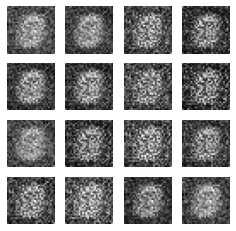

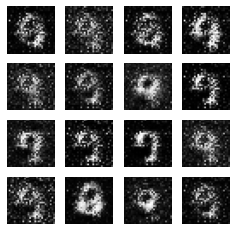

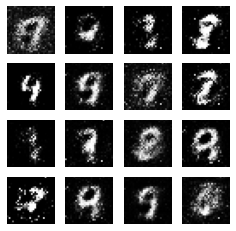

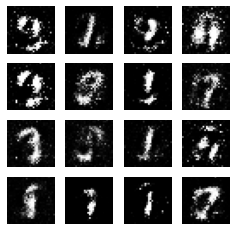

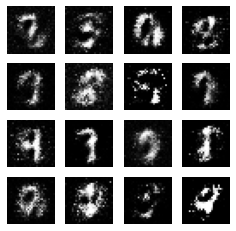

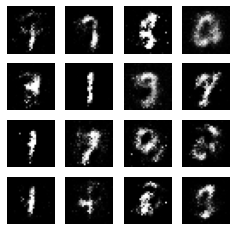

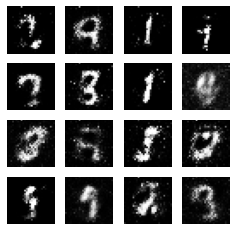

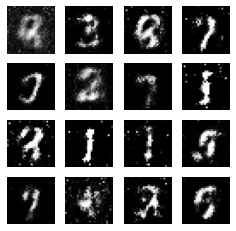

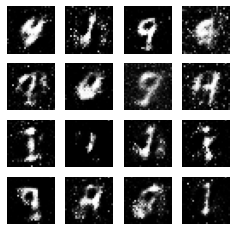

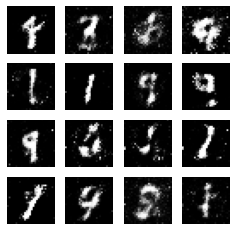

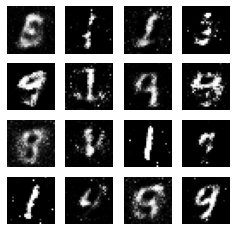

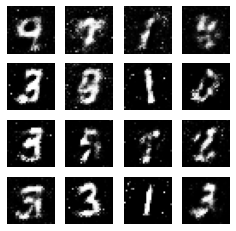

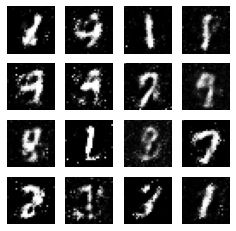

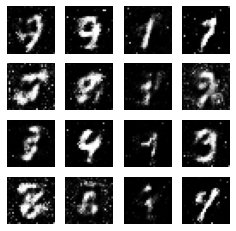

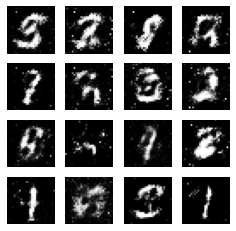

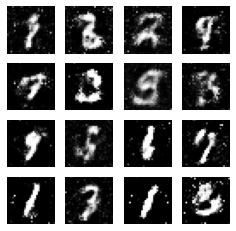

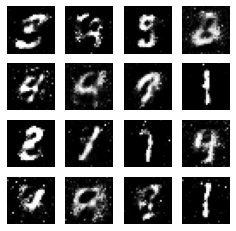

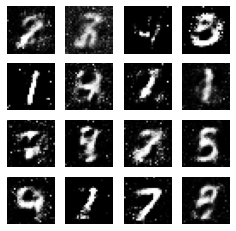

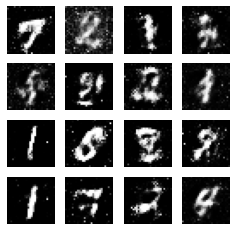

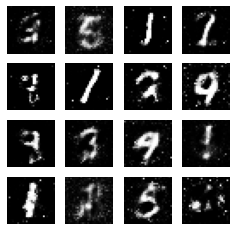

In [9]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval)

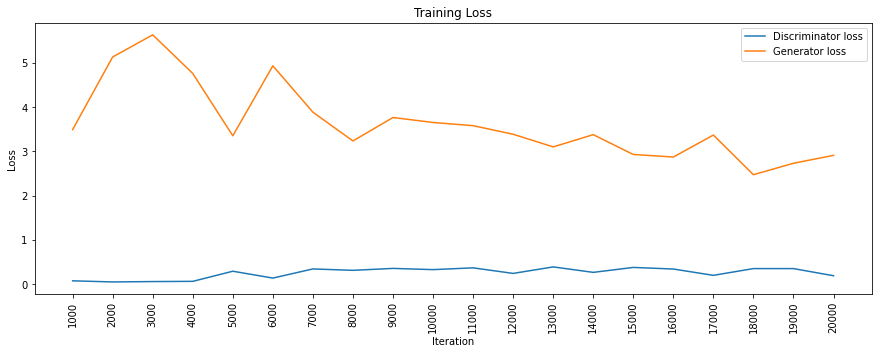

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

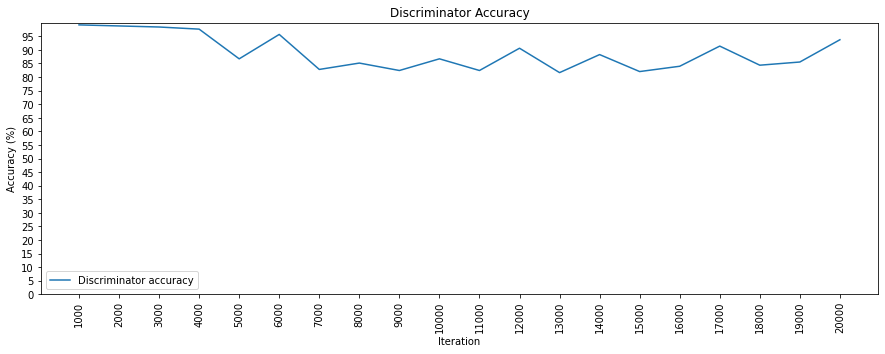

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()